In [1]:
# Compatibilidad con Python 3
from __future__ import print_function, division

import sys
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO

import geopandas as gpd
from geopandas import GeoDataFrame
import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    

import shapely as sy
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from time import sleep

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [21]:
# load NYC zips shapefiles with listings 
# generated on notebook 1 into geodataframe

filePath = "data/gdfListingsAllYearByZip.geojson"
gdf = GeoDataFrame.from_file(filePath)

In [22]:
# Get the charactersitics generate on notebook 2

filePath = "data/census_zip.csv"
dfZips = pd.read_csv(filePath)
dfZips.head()

,Unnamed: 0,Id,Id2,Geography,Percent; HOUSEHOLDS BY TYPE - Total households,Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families),Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families) - With own children of the householder under 18 years,Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families) - Married-couple family,Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families) - Married-couple family - With own children of the householder under 18 years,"Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families) - Male householder, no wife present, family",...,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder under 5 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder 5 to 17 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 to 64 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over
0,0,8600000US10001,10001,ZCTA5 10001,11639,31.5,10.1,23.5,7.0,3.4,...,20.4,59.5,59.5,18.6,69.3,14.9,15.9,8.6,23.6,17.2
1,1,8600000US10002,10002,ZCTA5 10002,33348,52.7,19.1,30.0,9.9,5.4,...,30.2,43.2,43.1,39.4,44.4,27.9,26.1,35.0,30.5,29.7
2,2,8600000US10003,10003,ZCTA5 10003,27487,26.7,8.3,22.3,6.1,1.7,...,10.3,7.6,6.3,6.3,6.3,10.5,10.4,11.0,4.1,14.2
3,3,8600000US10004,10004,ZCTA5 10004,1574,37.5,18.4,31.9,16.5,2.9,...,6.8,13.6,5.8,11.9,4.0,5.2,5.4,1.7,2.5,12.1
4,4,8600000US10005,10005,ZCTA5 10005,4252,29.9,12.3,26.5,10.7,1.6,...,10.6,0.0,0.0,0.0,0.0,11.7,11.8,0.0,0.2,17.6


In [23]:
# Rename zip column and merge
dfZips.rename(columns={'Id2': 'zip'}, inplace=True)
dfZips.zip = dfZips.zip.astype(str)

geoZips = pd.merge(gdf, dfZips, on=['zip'])
geoZips.zip = geoZips.zip.astype(str)
geoZips = GeoDataFrame(geoZips, geometry='geometry')

In [24]:
geoZips['listingsHouseholdsRatio'] = geoZips.listing/geoZips\
['Percent; HOUSEHOLDS BY TYPE - Total households']

In [25]:
geoZips['Percent; HOUSEHOLDS BY TYPE - Total households'].max()
geoZips.listing.min()
geoZips.listingsHouseholdsRatio.max()

inf

In [26]:
# Clean zips where ratio = inf
# (Lets do this better)
geoZips = geoZips[geoZips.listingsHouseholdsRatio != inf]

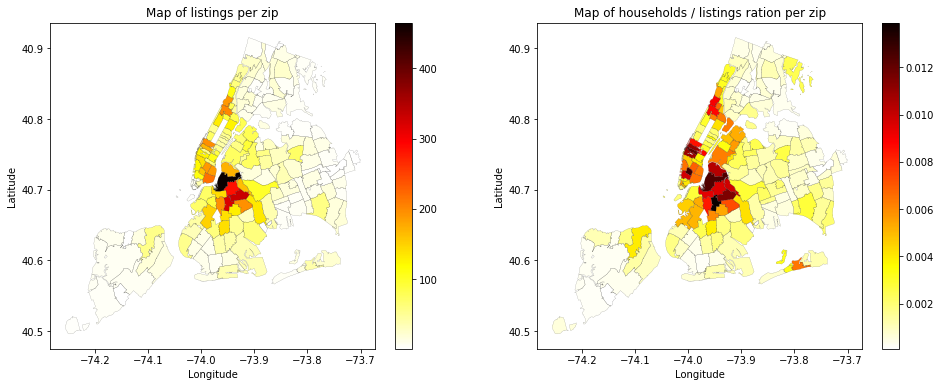

In [27]:
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot Total Listings Per Zip
geoZips.plot(column='listing', cmap='hot_r', alpha=1,
                        linewidth=0.1, ax=ax1)

ax1.set_title('Map of listings per zip')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=geoZips.listing.min(),
                              vmax=geoZips.listing.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(geoZips.listing)
pl.colorbar(scalarmappaple, ax=ax1)

# Plot listings household ratio per zip
geoZips.plot(column='listingsHouseholdsRatio', cmap='hot_r', alpha=1,
                        linewidth=0.1, ax=ax2)

ax2.set_title('Map of households / listings ration per zip')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=geoZips.listingsHouseholdsRatio.min(),
                              vmax=geoZips.listingsHouseholdsRatio.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(geoZips.listingsHouseholdsRatio)
pl.colorbar(scalarmappaple, ax=ax2)

In [28]:
geoZips.head()

,bcode,geometry,listing,note,zip,Unnamed: 0,Id,Geography,Percent; HOUSEHOLDS BY TYPE - Total households,Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families),...,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder under 5 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder 5 to 17 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 to 64 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,listingsHouseholdsRatio
0,36061,POLYGON ((-74.00368400000001 40.74835500003317...,126,None,10001,0,8600000US10001,ZCTA5 10001,11639,31.5,...,59.5,59.5,18.6,69.3,14.9,15.9,8.6,23.6,17.2,0.010826
1,36061,POLYGON ((-73.99694700000001 40.71207200003317...,217,None,10002,1,8600000US10002,ZCTA5 10002,33348,52.7,...,43.2,43.1,39.4,44.4,27.9,26.1,35.0,30.5,29.7,0.006507
2,36061,POLYGON ((-73.99206100000001 40.72564200003317...,190,None,10003,2,8600000US10003,ZCTA5 10003,27487,26.7,...,7.6,6.3,6.3,6.3,10.5,10.4,11.0,4.1,14.2,0.006912
3,36061,"(POLYGON ((-74.026658 40.68571500003317, -74.0...",3,None,10004,3,8600000US10004,ZCTA5 10004,1574,37.5,...,13.6,5.8,11.9,4.0,5.2,5.4,1.7,2.5,12.1,0.001906
4,36061,"POLYGON ((-74.009029 40.70531000003317, -74.00...",21,None,10005,4,8600000US10005,ZCTA5 10005,4252,29.9,...,0.0,0.0,0.0,0.0,11.7,11.8,0.0,0.2,17.6,0.004939


In [30]:
# Persist consolidated dataset
geoZips.to_file("data/consolidated.geojson",
                           driver='GeoJSON')

In [101]:
filePath = "data/consolidated.geojson"
geoZips = GeoDataFrame.from_file(filePath)

In [102]:
geoZips.head()

,Geography,Id,Percent; ANCESTRY - Total population,Percent; ANCESTRY - Total population - American,Percent; ANCESTRY - Total population - Arab,Percent; ANCESTRY - Total population - Czech,Percent; ANCESTRY - Total population - Danish,Percent; ANCESTRY - Total population - Dutch,Percent; ANCESTRY - Total population - English,Percent; ANCESTRY - Total population - French (except Basque),...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later,Unnamed: 0,bcode,geometry,listing,listingsHouseholdsRatio,note,zip
0,ZCTA5 10001,8600000US10001,23537,3.7,1.6,0.7,0.7,1.1,6.3,1.9,...,20.3,7.1,1.0,0,36061,POLYGON ((-74.00368400000001 40.74835500003317...,126,0.010826,None,10001
1,ZCTA5 10002,8600000US10002,80736,2.4,0.4,0.1,0.0,0.2,1.4,1.0,...,4.7,0.4,0.0,1,36061,POLYGON ((-73.99694700000001 40.71207200003317...,217,0.006507,None,10002
2,ZCTA5 10003,8600000US10003,57112,3.7,0.8,0.4,0.3,0.6,6.9,2.1,...,3.3,0.4,0.0,2,36061,POLYGON ((-73.99206100000001 40.72564200003317...,190,0.006912,None,10003
3,ZCTA5 10004,8600000US10004,3221,8.4,0.2,1.5,0.7,0.6,8.2,2.9,...,14.0,0.0,0.0,3,36061,"(POLYGON ((-74.026658 40.68571500003317, -74.0...",3,0.001906,None,10004
4,ZCTA5 10005,8600000US10005,8131,2.5,1.9,0.0,2.3,0.7,6.6,3.0,...,18.0,1.2,0.0,4,36061,"POLYGON ((-74.009029 40.70531000003317, -74.00...",21,0.004939,None,10005


In [35]:
# Load information from the American Factfinder
# Regarding traveler accomodation establishments

# Get the charactersitics generate on notebook 2

filePath = "data/ALL_Hotels_by_ZIP.csv"
dfHotels = pd.read_csv(filePath)
dfHotels.head()

,GEO.id,Zipcode,GEO.display-label,NAICS.id,NAICS.display-label,RCPSZFE.id,RCPSZFE.display-label,YEAR.id,ESTAB
0,8610000US10001,10001,"ZIP 10001 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,33
1,8610000US10002,10002,"ZIP 10002 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,11
2,8610000US10003,10003,"ZIP 10003 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,12
3,8610000US10004,10004,"ZIP 10004 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,2
4,8610000US10005,10005,"ZIP 10005 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,4


In [46]:
# Load the average hotel rooms per hotel by borough
filePath = "data/avg_rooms_per_hotel_by_boro.csv"
dfHotelRoomsAverage = pd.read_csv(filePath)
dfHotelRoomsAverage.head()

,bcode,AVG_Rooms_per_Hotel,boro
0,36061,239.947236,Manhattan
1,36085,70.727273,Staten Island
2,36005,38.857143,Bronx
3,36081,130.468085,Queens
4,36047,106.303571,Brooklyn


In [86]:
# Prepare columns and merge
dfHotelRoomsAverage['bcode'] = pd.to_numeric(dfHotelRoomsAverage['bcode'])

In [103]:
# Initialize the coordinate reference system for the geodataframe
geoZips.crs = {'init' :'epsg:4326'}

In [104]:
# Calculate the area in square miles for each of the zips
geoZips['sq_mi_area'] = geoZips.to_crs(epsg=2263).geometry.area/(2.788*10**7)

In [105]:
geoZips.head()

,Geography,Id,Percent; ANCESTRY - Total population,Percent; ANCESTRY - Total population - American,Percent; ANCESTRY - Total population - Arab,Percent; ANCESTRY - Total population - Czech,Percent; ANCESTRY - Total population - Danish,Percent; ANCESTRY - Total population - Dutch,Percent; ANCESTRY - Total population - English,Percent; ANCESTRY - Total population - French (except Basque),...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later,Unnamed: 0,bcode,geometry,listing,listingsHouseholdsRatio,note,zip,sq_mi_area
0,ZCTA5 10001,8600000US10001,23537,3.7,1.6,0.7,0.7,1.1,6.3,1.9,...,7.1,1.0,0,36061,POLYGON ((-74.00368400000001 40.74835500003317...,126,0.010826,None,10001,0.621352
1,ZCTA5 10002,8600000US10002,80736,2.4,0.4,0.1,0.0,0.2,1.4,1.0,...,0.4,0.0,1,36061,POLYGON ((-73.99694700000001 40.71207200003317...,217,0.006507,None,10002,0.879359
2,ZCTA5 10003,8600000US10003,57112,3.7,0.8,0.4,0.3,0.6,6.9,2.1,...,0.4,0.0,2,36061,POLYGON ((-73.99206100000001 40.72564200003317...,190,0.006912,None,10003,0.576412
3,ZCTA5 10004,8600000US10004,3221,8.4,0.2,1.5,0.7,0.6,8.2,2.9,...,0.0,0.0,3,36061,"(POLYGON ((-74.026658 40.68571500003317, -74.0...",3,0.001906,None,10004,0.559690
4,ZCTA5 10005,8600000US10005,8131,2.5,1.9,0.0,2.3,0.7,6.6,3.0,...,1.2,0.0,4,36061,"POLYGON ((-74.009029 40.70531000003317, -74.00...",21,0.004939,None,10005,0.073514


In [45]:
# Merge the hotels data with the consolidated dataset

In [53]:
# Rename zip column and merge
dfHotels.rename(columns={'Zipcode': 'zip'}, inplace=True)
dfHotels.zip = dfHotels.zip.astype(str)

In [106]:
geoZips = pd.merge(geoZips, dfHotels, on=['zip'])
geoZips = GeoDataFrame(geoZips, geometry='geometry')

In [107]:
geoZips.head()

,Geography,Id,Percent; ANCESTRY - Total population,Percent; ANCESTRY - Total population - American,Percent; ANCESTRY - Total population - Arab,Percent; ANCESTRY - Total population - Czech,Percent; ANCESTRY - Total population - Danish,Percent; ANCESTRY - Total population - Dutch,Percent; ANCESTRY - Total population - English,Percent; ANCESTRY - Total population - French (except Basque),...,zip,sq_mi_area,GEO.id,GEO.display-label,NAICS.id,NAICS.display-label,RCPSZFE.id,RCPSZFE.display-label,YEAR.id,ESTAB
0,ZCTA5 10001,8600000US10001,23537,3.7,1.6,0.7,0.7,1.1,6.3,1.9,...,10001,0.621352,8610000US10001,"ZIP 10001 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,33
1,ZCTA5 10002,8600000US10002,80736,2.4,0.4,0.1,0.0,0.2,1.4,1.0,...,10002,0.879359,8610000US10002,"ZIP 10002 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,11
2,ZCTA5 10003,8600000US10003,57112,3.7,0.8,0.4,0.3,0.6,6.9,2.1,...,10003,0.576412,8610000US10003,"ZIP 10003 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,12
3,ZCTA5 10004,8600000US10004,3221,8.4,0.2,1.5,0.7,0.6,8.2,2.9,...,10004,0.559690,8610000US10004,"ZIP 10004 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,2
4,ZCTA5 10005,8600000US10005,8131,2.5,1.9,0.0,2.3,0.7,6.6,3.0,...,10005,0.073514,8610000US10005,"ZIP 10005 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,4


In [108]:
geoZips['bcode'] = pd.to_numeric(geoZips['bcode'])

geoZips = pd.merge(geoZips, dfHotelRoomsAverage, on=['bcode'])
geoZips = GeoDataFrame(geoZips, geometry='geometry')

In [109]:
geoZips.head()

,Geography,Id,Percent; ANCESTRY - Total population,Percent; ANCESTRY - Total population - American,Percent; ANCESTRY - Total population - Arab,Percent; ANCESTRY - Total population - Czech,Percent; ANCESTRY - Total population - Danish,Percent; ANCESTRY - Total population - Dutch,Percent; ANCESTRY - Total population - English,Percent; ANCESTRY - Total population - French (except Basque),...,GEO.id,GEO.display-label,NAICS.id,NAICS.display-label,RCPSZFE.id,RCPSZFE.display-label,YEAR.id,ESTAB,AVG_Rooms_per_Hotel,boro
0,ZCTA5 10001,8600000US10001,23537,3.7,1.6,0.7,0.7,1.1,6.3,1.9,...,8610000US10001,"ZIP 10001 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,33,239.947236,Manhattan
1,ZCTA5 10002,8600000US10002,80736,2.4,0.4,0.1,0.0,0.2,1.4,1.0,...,8610000US10002,"ZIP 10002 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,11,239.947236,Manhattan
2,ZCTA5 10003,8600000US10003,57112,3.7,0.8,0.4,0.3,0.6,6.9,2.1,...,8610000US10003,"ZIP 10003 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,12,239.947236,Manhattan
3,ZCTA5 10004,8600000US10004,3221,8.4,0.2,1.5,0.7,0.6,8.2,2.9,...,8610000US10004,"ZIP 10004 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,2,239.947236,Manhattan
4,ZCTA5 10005,8600000US10005,8131,2.5,1.9,0.0,2.3,0.7,6.6,3.0,...,8610000US10005,"ZIP 10005 (New York, NY)",7211,Traveler accommodation,1,All establishments,2012,4,239.947236,Manhattan


In [110]:
# Add hotel rooms per square mile for each of the zips
geoZips['hotel_rooms_per_sqmi'] = (geoZips.AVG_Rooms_per_Hotel * geoZips.ESTAB) / geoZips.sq_mi_area
geoZips['listings_per_sqmi'] = geoZips.listing / geoZips.sq_mi_area

In [111]:
# Adding the subway, trees and parks counts per zip
dfSubwayParksTrees = pd.read_csv('data/sub_tree_park.csv')
dfSubwayParksTrees.head()

,Unnamed: 0,note,zip,listing,subway_stops,stop_density,park_area,geometry,tree_count,zip_area,tree_density
0,0,NaN,10001,126,7,4.349437e-06,0.005287,"MULTIPOLYGON (((-74.00368400000001 40.748355, ...",911,0.621352,1466.158257
1,1,NaN,10002,217,5,2.195217e-06,0.158087,"MULTIPOLYGON (((-73.99694700000001 40.712072, ...",2265,0.879359,2575.740552
2,2,NaN,10003,190,7,4.688546e-06,0.037266,"MULTIPOLYGON (((-73.99206100000001 40.725642, ...",2025,0.576412,3513.112743
3,3,NaN,10007,10,7,1.653443e-05,0.015715,"MULTIPOLYGON (((-74.010465 40.711535, -74.0101...",355,0.163449,2171.931016
4,4,NaN,10009,188,1,6.261801e-07,0.045228,"MULTIPOLYGON (((-73.97520799999999 40.719243, ...",1924,0.616558,3120.550017


In [112]:
dfSubwayParksTrees = dfSubwayParksTrees[['tree_count','zip_area','tree_density',
                                        'stop_density','park_area','zip']]
dfSubwayParksTrees.head()
dfSubwayParksTrees.zip = dfSubwayParksTrees.zip.astype(str)


In [113]:
geoZips = pd.merge(geoZips, dfSubwayParksTrees, on=['zip'])
geoZips = GeoDataFrame(geoZips, geometry='geometry')


In [114]:
geoZips.head()

,Geography,Id,Percent; ANCESTRY - Total population,Percent; ANCESTRY - Total population - American,Percent; ANCESTRY - Total population - Arab,Percent; ANCESTRY - Total population - Czech,Percent; ANCESTRY - Total population - Danish,Percent; ANCESTRY - Total population - Dutch,Percent; ANCESTRY - Total population - English,Percent; ANCESTRY - Total population - French (except Basque),...,ESTAB,AVG_Rooms_per_Hotel,boro,hotel_rooms_per_sqmi,listings_per_sqmi,tree_count,zip_area,tree_density,stop_density,park_area
0,ZCTA5 10001,8600000US10001,23537,3.7,1.6,0.7,0.7,1.1,6.3,1.9,...,33,239.947236,Manhattan,12743.601000,202.783689,911,0.621352,1466.158257,0.000004,0.005287
1,ZCTA5 10002,8600000US10002,80736,2.4,0.4,0.1,0.0,0.2,1.4,1.0,...,11,239.947236,Manhattan,3001.527635,246.770728,2265,0.879359,2575.740552,0.000002,0.158087
2,ZCTA5 10003,8600000US10003,57112,3.7,0.8,0.4,0.3,0.6,6.9,2.1,...,12,239.947236,Manhattan,4995.328552,329.625393,2025,0.576412,3513.112743,0.000005,0.037266
3,ZCTA5 10004,8600000US10004,3221,8.4,0.2,1.5,0.7,0.6,8.2,2.9,...,2,239.947236,Manhattan,857.428784,5.360108,118,0.559690,210.830927,0.000002,0.115819
4,ZCTA5 10006,8600000US10006,3110,2.3,0.9,1.3,0.0,1.2,8.9,3.4,...,3,239.947236,Manhattan,7841.183104,108.929269,53,0.091803,577.325125,0.000013,0.002311


In [116]:
# Persist consolidated dataset
geoZips.to_file("data/consolidated.geojson",
                           driver='GeoJSON')